# Conversion Rate 

## Goal: 

The goal of this challenge is to build a model that **predicts conversion rate** and, based on the
model, come up with ideas to improve revenues.

## Data

We have a table that contains information about signed-in users during one session. Each row is a user session.

**Columns**:

- **country** : user country based on the IP address
- **age** : user age. Self-reported at sign-in step
* **new_user** : whether the user created the account during this session or had already an
account and simply came back to the site
- **source** : marketing channel source
 * Ads: came to the site by clicking on an advertisement
 - Seo: came to the site by clicking on search results
 - Direct: came to the site by directly typing the URL on the browser


- **total_pages_visited**: number of total pages visited during the session. This is a proxy for
time spent on site and engagement during the session


- **converted**: this is our label. 1 means they converted within the session, 0 means they left
without buying anything. The company goal is to increase conversion rate: # conversions
/ total sessions

### Import dependencies

In [1]:
# Import main libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import Classifiers 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, partial_dependence
from sklearn.ensemble.partial_dependence import plot_partial_dependence

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
# Import Model Evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve

In [4]:
# Import Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_curve

In [5]:
# Import preprocessing tools
from sklearn.preprocessing import LabelEncoder, imputation, StandardScaler

### Read in the data

In [6]:
path = './conversion_data.csv'
df = pd.read_csv(path)

# Check first 5 rows of the dataframe to get a sense of the data
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


### Explore the dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [8]:
df.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,316200.0,30.569858,8.271802,17.0,24.0,30.0,36.0,123.0
new_user,316200.0,0.685465,0.464331,0.0,0.0,1.0,1.0,1.0
total_pages_visited,316200.0,4.872966,3.341104,1.0,2.0,4.0,7.0,29.0
converted,316200.0,0.032258,0.176685,0.0,0.0,0.0,0.0,1.0


In [10]:
df.describe(include=['O']).T

,count,unique,top,freq
country,316200,4,US,178092
source,316200,3,Seo,155040


A few quick observations:
- there are no missing values
- the site is probably a US site, although it does have a large Chinese user base as well
- user base is pretty young
- conversion rate at around 3% is industry standard. It makes sense
- everything seems to make sense here except for max age 123 yrs

### Data Cleaning

In [11]:
# print unique values of each column to gain high level perspective of the data
for col_name in df.columns:
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))
        print("They are:", df[col_name].unique(), '\n' )

Feature 'country' has 4 unique categories
They are: ['UK' 'US' 'China' 'Germany'] 

Feature 'age' has 60 unique categories
They are: [ 25  23  28  39  30  31  27  29  38  43  24  36  37  33  20  35  17  50
  22  18  34  19  42  32  21  48  40  41  26  45  44  49  46  56  52  54
  51  47  53  60  57  55  59  61  58  62  65  63  66  67  64  68  69 123
  70  73  77  72  79 111] 

Feature 'new_user' has 2 unique categories
They are: [1 0] 

Feature 'source' has 3 unique categories
They are: ['Ads' 'Seo' 'Direct'] 

Feature 'total_pages_visited' has 29 unique categories
They are: [ 1  5  4  6  2  8  7  3  9 14 10 11 18 15 19 12 13 21 17 23 16 25 26 20
 22 24 27 28 29] 

Feature 'converted' has 2 unique categories
They are: [0 1] 



The data seems reasonable as per initial description, apart from 'Age'. Let's sort this series

In [12]:
np.sort(df.age.unique())

array([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  72,  73,  77,  79, 111, 123], dtype=int64)

In [13]:
# Some ages are clearly out of the range in the right tail of the distribution. How many?
df.query('age>79')

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


Only two observations are probably wrong. We can then safely remove them from the original dataset

In [14]:
df = df.query('age<79')

### EDA (Exploratory Data Analysis)

In [15]:
# plotting settings
#plt.style.use('seaborn-whitegrid')
plt.style.use("ggplot")
figsize=(20,6)

###### Examine labels distribution (Conversion Rate)

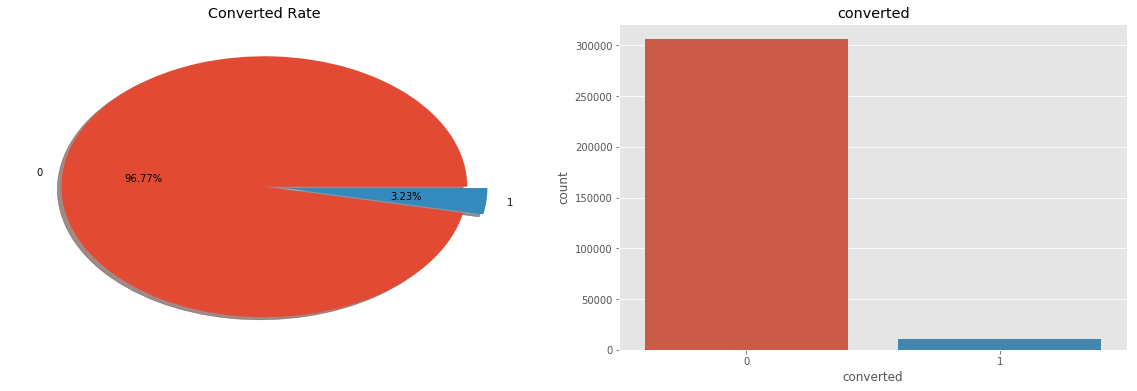

In [16]:
f, ax = plt.subplots(1,2,figsize=figsize)
df['converted'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%',ax=ax[0],shadow=True)
ax[0].set_title('Converted Rate')
ax[0].set_ylabel('')
sns.countplot('converted', data=df, ax=ax[1])
ax[1].set_title('converted')
plt.show()

###### Conversion by Country

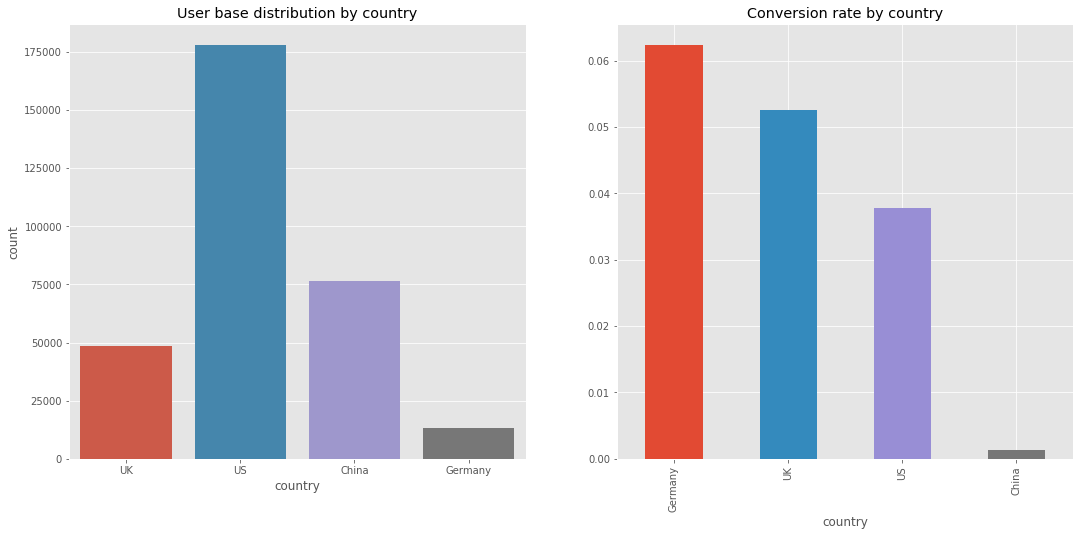

In [17]:
f, ax = plt.subplots(1,2,figsize=(18,8))
sns.countplot('country', data=df, ax=ax[0])
ax[0].set_title('User base distribution by country')
df.groupby('country').converted.mean().sort_values(ascending=False).plot(kind='bar')
ax[1].set_title('Conversion rate by country');

Conversion rate is by far higher in Germany and Uk, despite the majority of the users being located in USA. Also chinese users
conversion rate appears much lesser than the others. Could be worthwhile to investigate chinese users deeper and compare them with the others

In [18]:
df.groupby('country').mean()

,age,new_user,total_pages_visited,converted
country,,,,
China,30.672972,0.698520,4.553523,0.001332
Germany,30.442895,0.677288,5.189966,0.062428
UK,30.449875,0.679849,5.082066,0.052612
US,30.566211,0.681983,4.930182,0.037801


from the table above we can see that average parameters are not much different among them, therefore we can exclude that lower chinese conversion rate is imputable to different age distributions, or type of customers.

###### Conversion by source

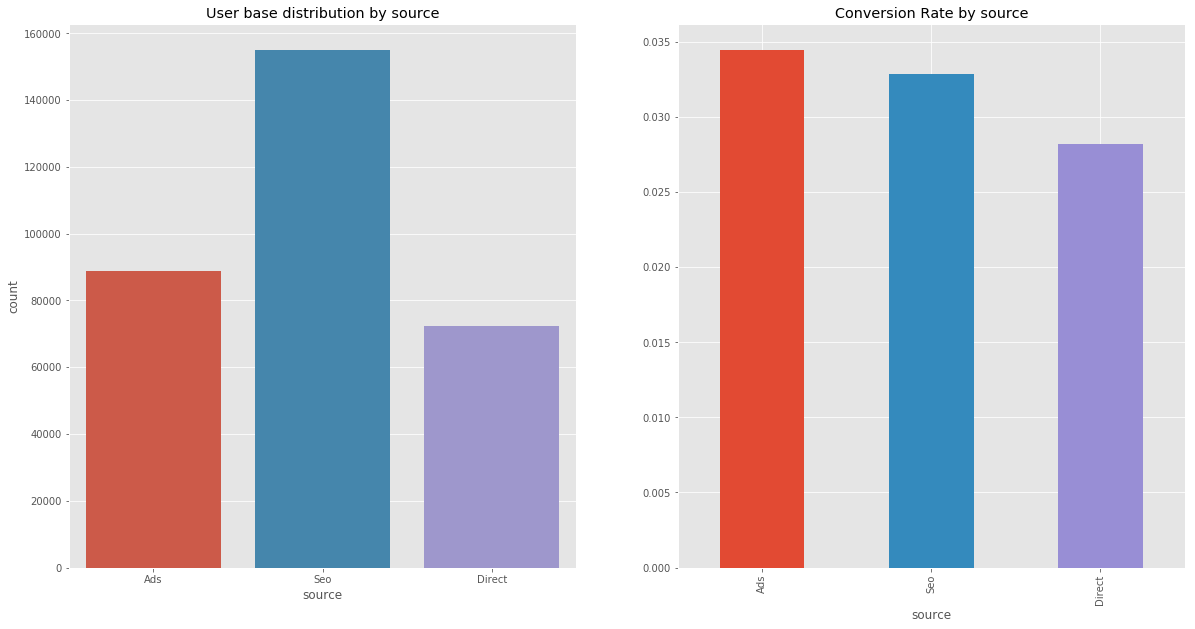

In [19]:
f, ax = plt.subplots(1,2,figsize=(20,10))
sns.countplot('source', data=df, ax=ax[0])
ax[0].set_title('User base distribution by source')
df.groupby('source').converted.mean().sort_values(ascending=False).plot.bar()
ax[1].set_title('Conversion Rate by source');

Source does not appear to be a variable affecting conversion in a substantial way 

###### Conversion by new_user

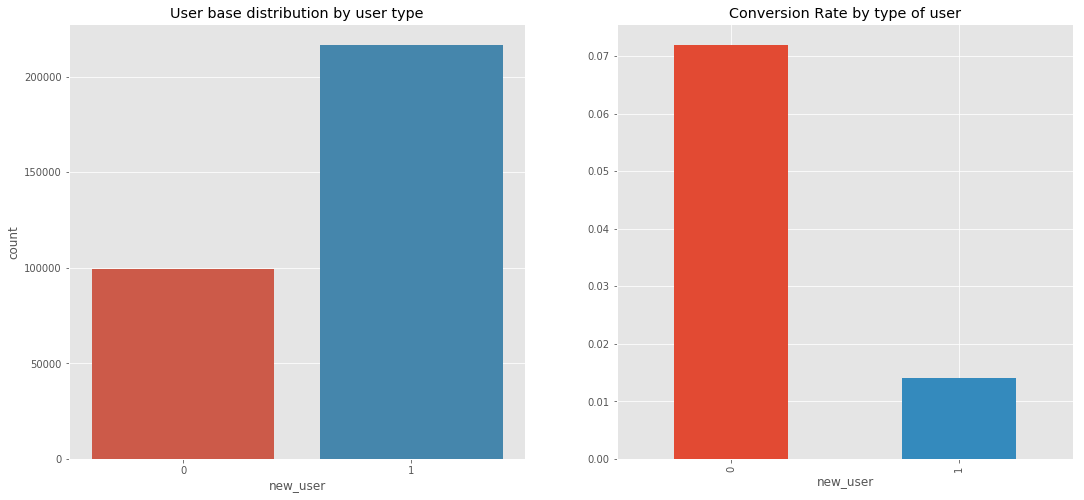

In [20]:
f, ax = plt.subplots(1,2,figsize=(18,8))
sns.countplot('new_user', data=df, ax=ax[0])
ax[0].set_title('User base distribution by user type')
df.groupby('new_user').converted.mean().sort_values(ascending=False).plot.bar()
ax[1].set_title('Conversion Rate by type of user');

Definitively being an old user impact on conversion rate in a positive way

###### Conversion by pages visited

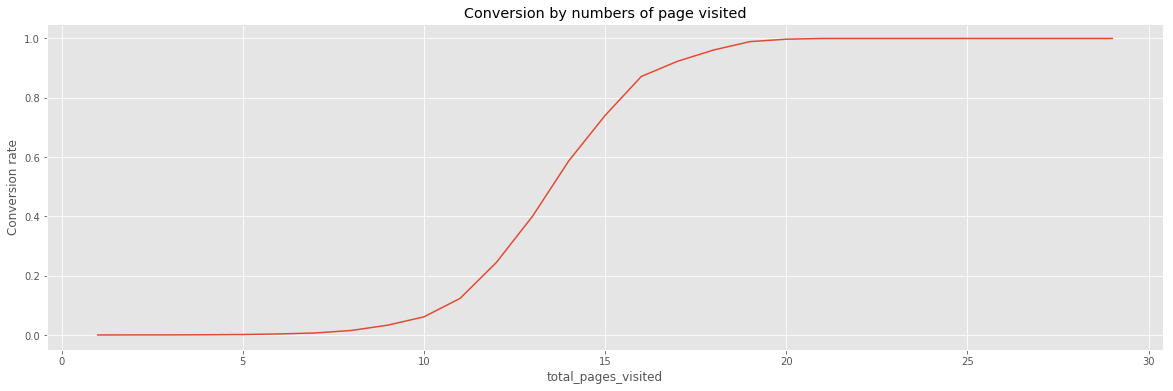

In [21]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Conversion by numbers of page visited'), ax.set_ylabel('Conversion rate')
df.groupby('total_pages_visited').converted.mean().sort_values(ascending=False).plot();

Total number of pages visited by users is directly correlated with conversion. Users who visit more than 20 pages end up converting all the times. Thererefore # of pages visited is a very strong indicator of purchase desire.

###### Conversion by user age

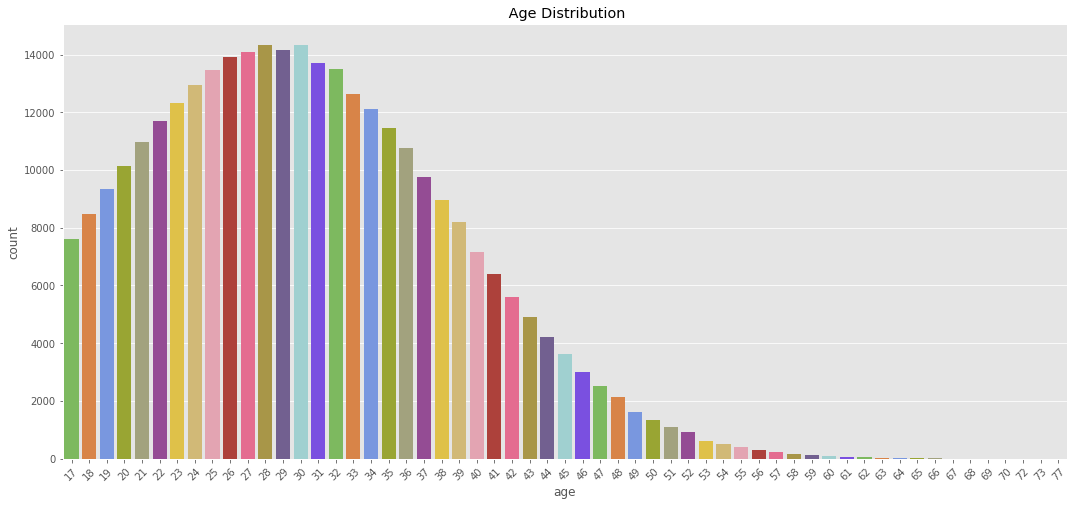

In [22]:
# Age distribution
# Types of colors
f, ax = plt.subplots(1,figsize=(18,8))
color_types = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878','#A040A0','#F8D030',  
                '#E0C068','#EE99AC','#C03028','#F85888','#B8A038','#705898','#98D8D8','#7038F8']

# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='age', data=df, palette=color_types).set_title(' Age Distribution');
 
# Rotate x-labels
plt.xticks(rotation=45);

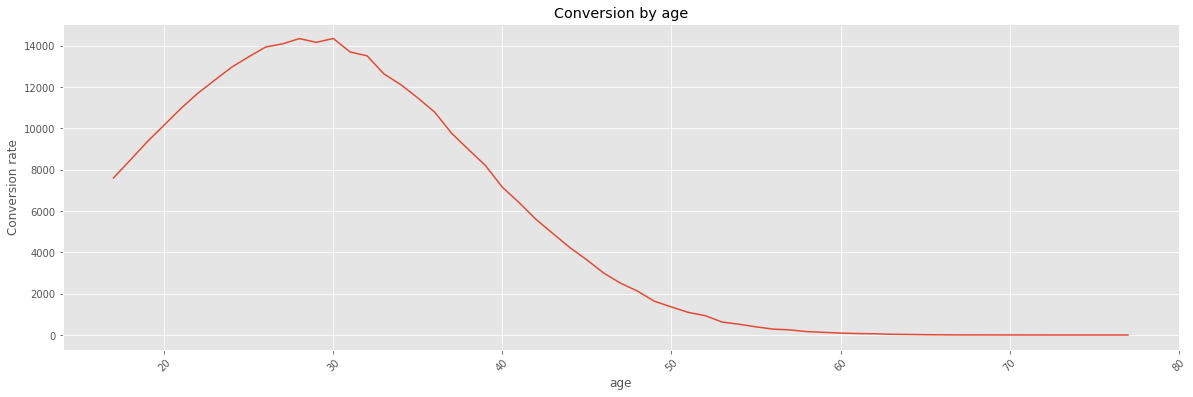

In [23]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Conversion by age'), ax.set_ylabel('Conversion rate')
df.groupby('age').converted.count().plot.line()
# Rotate x-labels
plt.xticks(rotation=45);

Younger users tend to have a higher conversion rate

### Data processing for Machine Learning Analysis

We now process the dataset in order to feed the data to the ML model we are going to select. 

######  Create Feature Matrix X

In [24]:
# slice the dataframe from the first column to the last but one
feature_names = df.columns.values[:-1]
X = df[feature_names].copy() # make a copy of the original dataframe to avoid warning error
X.shape

(316197, 5)

###### Label encoding of categorical features

In [25]:
lb = LabelEncoder() # instantiate the encoder
for feature in X.select_dtypes(include = ['O']).columns.values: # loop through all the feature spaces and pick only the categorical variables
    X[feature]= lb.fit_transform(X[feature])

In [26]:
X.info() # final check on feature matrix X values 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316197 entries, 0 to 316199
Data columns (total 5 columns):
country                316197 non-null int64
age                    316197 non-null int64
new_user               316197 non-null int64
source                 316197 non-null int64
total_pages_visited    316197 non-null int64
dtypes: int64(5)
memory usage: 14.5 MB


Feature matrix full of numeric values only and showing no presence of missing values. Ready for manipulation

###### Create response vector y

In [27]:
y = df.converted # label

### Cross validation

In [28]:
# split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

### Model Selection

We will try now to select the best model to obtain predictions. The 1st model we try is: 

###### Random Forest

In [29]:
#instantiate the model
rf = RandomForestClassifier(n_estimators=100, # to speed up process time and obtain acceptable results
                            n_jobs=-1,        # to exploit all cores
                            random_state=23,  # for reproducibility
                            oob_score=True)  # to exploit internal cross validation tool of RF classifier

In [30]:
# train the model
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=23, verbose=0, warm_start=False)

In [31]:
# calculate the accuracy of the model on training set
training_accuracy = rf.score(X_train, y_train) 
print('Accuracy of Training set = {}'.format(training_accuracy))

Accuracy of Training set = 0.9885438350538822


Training accuracy is very high, no chance of underfitting, hence we can be sure the model is no biased

In [32]:
print('Cross Validation accuracy =', rf.oob_score_)

Cross Validation accuracy = 0.9841917196520196


Cross validation accuracy is very close to training accuracy, hence the model is no overfitting

In [33]:
# predict conversion rate on unseen data X_test
y_pred = rf.predict(X_test)
test_score = rf.score(X_test, y_test)
print('Testing Accuracy =', test_score)

Testing Accuracy = 0.9844172273014777


The model seems to have a high acccuracy, but we first of all have to compare it with so-called nulled accuracy, which is the most predicted class percentage. For a binary classification can be easily calculated as:

In [34]:
Null_Accuracy = max(y_test.mean(), 1-y_test.mean()) 
print('Null Accuracy= {:.4f}'.format (Null_Accuracy)) # Baseline for model evaluation

Null Accuracy= 0.9682


Random Forest Model with no parameter optimization have a slighly higher accuracy than a dummy regressor, but due to the high class imbalance we have to bring onto the table other metrics to better evaluate model performance, namely:precision, recall, roc_auc score

In [35]:
print('Classification Report=\n\n',(classification_report(y_test, y_pred)))

Classification Report=

              precision    recall  f1-score   support

          0       0.99      0.99      0.99    101028
          1       0.80      0.68      0.74      3318

avg / total       0.98      0.98      0.98    104346



In [36]:
print('Confusion Matrix =\n\n',confusion_matrix(y_test, y_pred))

Confusion Matrix =

 [[100457    571]
 [  1055   2263]]


**Recall of the model is 0.68**, that means the model is able to catch only 68% of true conversion, in fact 1055 customers of the test set, who converted are not correctly classified by the model.

**Precision of the model is 0.80** that means that the model is correct 80% of the times it predicts a conversion, in fact 571 users of the test set data, who were predicted as acquiring customers have not purchased anything.


In [37]:
y_pred_proba = rf.predict_proba(X_test)[:,1] # model predicted probability of class 1
rf_roc_auc = roc_auc_score(y_test, y_pred_proba)
print('Random Forest AUC Score =', round(rf_roc_auc,3))

Random Forest AUC Score = 0.948


###### ROC Curve

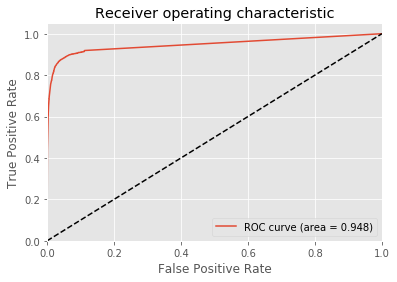

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Plotting Learning Curves

In [39]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(20,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training set sizes")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_error_mean = 1-np.mean(train_scores, axis=1)
    test_error_mean = 1- np.mean(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_error_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_error_mean, 'o-', color="g",
             label="Cross-validation error")

    plt.legend(loc="best")
    return plt

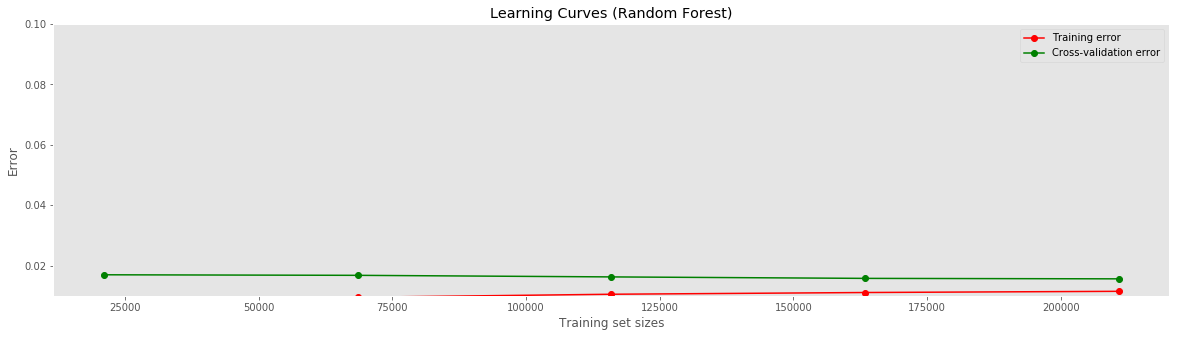

In [40]:
title = "Learning Curves (Random Forest)"
plot_learning_curve(rf, title, X, y, ylim=(0.01, 0.1), cv=None, n_jobs=-1);

###  Feature importances

Using Random Forest model proves to be advantageous also for the automatic calculation of feature importances made it available in feature_importances  attribute

In [41]:
rf.feature_importances_

array([0.04530216, 0.11163224, 0.03870949, 0.01706091, 0.78729521])

In [42]:
#zip the array and sort it
for feature in sorted(list(zip(rf.feature_importances_, X)), reverse=True):
    print(feature)

(0.7872952098528646, 'total_pages_visited')
(0.11163223647975914, 'age')
(0.04530215750528544, 'country')
(0.03870948913037232, 'new_user')
(0.01706090703171859, 'source')


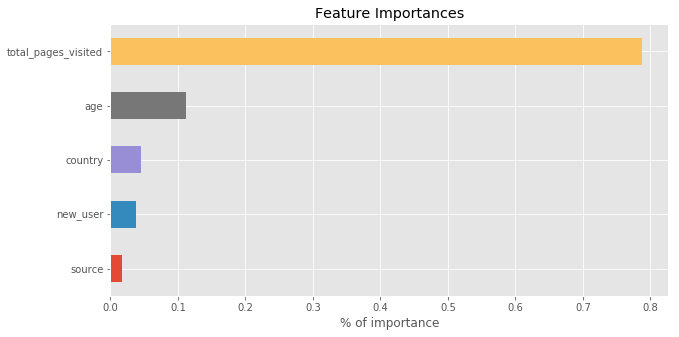

In [43]:
# Chart a visual representation
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh', figsize=(10,5))
plt.title('Feature Importances'), plt.xlabel('% of importance');

Total pages visited is the most important one, by far. Unfortunately, it is probably the least “actionable”.
People visit many pages cause they already want to buy. Also, in order to buy you have to click on
multiple pages.
Let’s rebuild the RF without that variable.   Since classes are heavily unbalanced and we don’t have that
very powerful variable anymore, let’s change the weight a bit, just to make sure we will get something
classified as 1.

In [44]:
X_new = X.drop('total_pages_visited', axis='columns').copy() # drop the undesired feature

In [45]:
X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y, random_state=42, test_size=0.33)

In [46]:
rf = RandomForestClassifier(n_estimators=100, # to speed up process time and obtain acceptable results
                            n_jobs=-1,        # to exploit all cores
                            random_state=23,  # for reproducibility
                            oob_score=True, # to exploit internal cross validation tool of RF classifier
                            class_weight='balanced' ) # to avoid to obtain only '0'

In [47]:
rf.fit(X_new_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=23,
            verbose=0, warm_start=False)

In [48]:
print('New Testing Accuracy after feature reduction is =', rf.score(X_new_test, y_test))

New Testing Accuracy after feature reduction is = 0.748615184099055


Testing Accuracy went down a little bit, but is still acceptable for our purpose. What are the changes for other metrics?

In [49]:
y_new_pred = rf.predict(X_new_test)
print(classification_report(y_test, y_new_pred))

             precision    recall  f1-score   support

          0       0.99      0.75      0.85    101028
          1       0.09      0.73      0.16      3318

avg / total       0.96      0.75      0.83    104346



In [50]:
print(confusion_matrix(y_test, y_new_pred))

[[75694 25334]
 [  897  2421]]


From classification report we can see that Recall remained kind of stable, whereas Precision went down the roof. We can still use this revised model to gain insights on feature importances. Then let's replot feature importances horizontal diagram with the reducted features

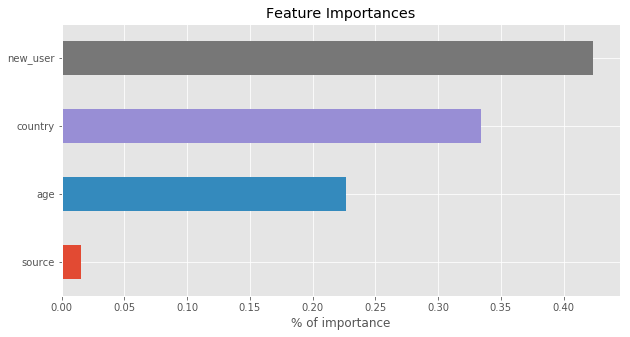

In [51]:
feature_importances = pd.Series(rf.feature_importances_, index=X_new.columns).sort_values().plot(kind='barh', figsize=(10,5))
plt.title('Feature Importances'), plt.xlabel('% of importance');

We can now see that feature importances calculations confirm what we could already foresee from initial EDA, namely:
- new_user is the variable that most affects conversion
- country is another important discriminating variable
- source does not bring any contribute to the label

###### Decision Tree classifier 

Let’s now build a simple decision tree and check the 2 or 3 most important segments to confirm our conclusion, also to have a rough idea about discriminating values about the features we have identified as predictive

In [52]:
tree = DecisionTreeClassifier(max_depth=3, random_state=0)
tree.fit(X_new, y)
export_graphviz(tree, out_file='tree.dot', feature_names=X_new.columns, class_names=['not converted', 'CONVERTED'],
               impurity=False, filled=True, node_ids= True, proportion=False, rounded=True)

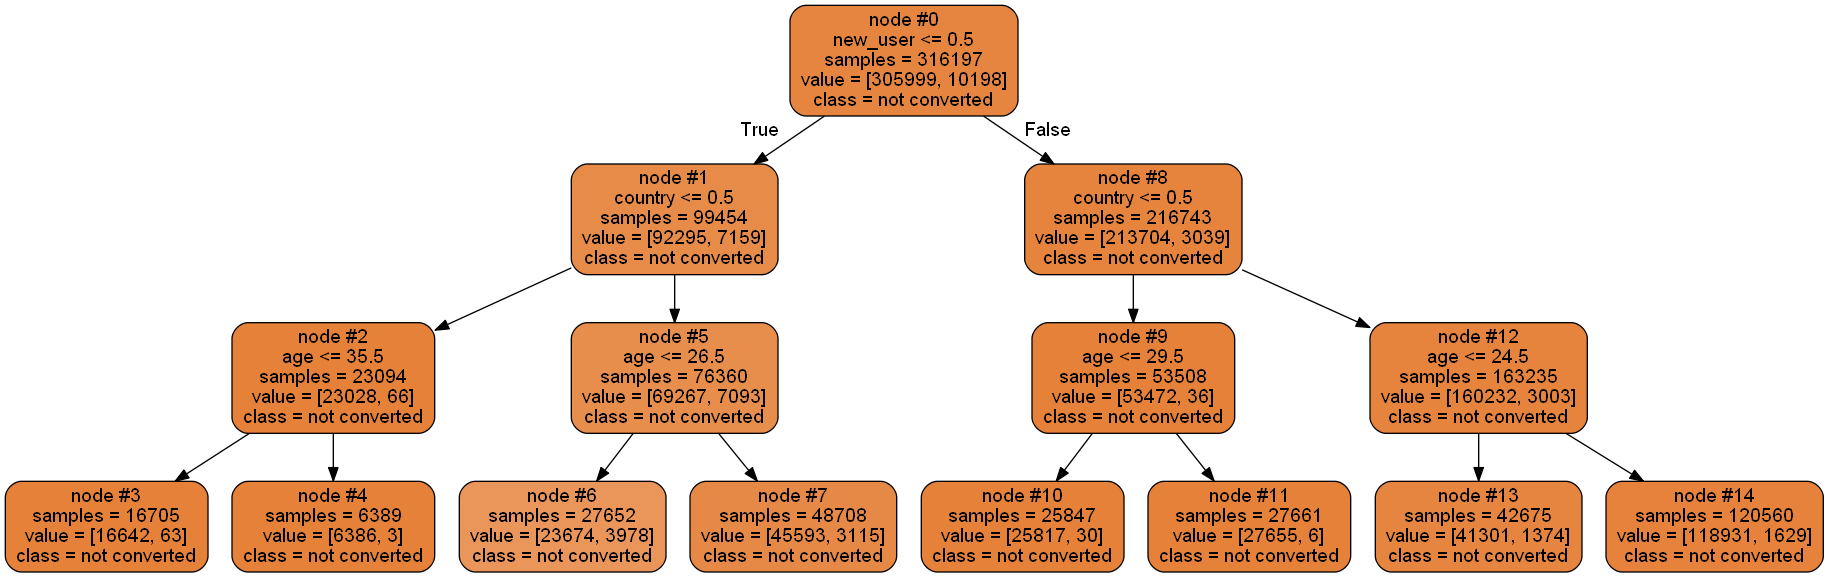

In [53]:
from IPython.display import Image
Image(filename='tree.png') 

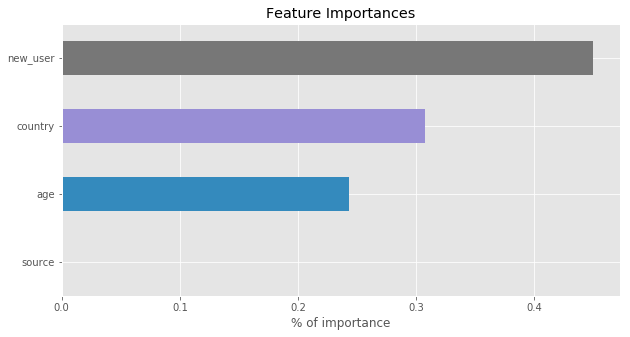

In [54]:
feature_importances = pd.Series(tree.feature_importances_, index=X_new.columns).sort_values().plot(kind='barh', figsize=(10,5))
plt.title('Feature Importances'), plt.xlabel('% of importance');


Decision tree splits on the same variables we have previously identified, emphasizing the dipendence of the conversion from this parameters. 

Let's use another model for exploiting partial dependence plot available for this model

###### GRADIENT BOOSTING REGRESSION

In [55]:
#instantiate the classifier
est =GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1,
                                           min_samples_leaf=3, 
                                          random_state=0)

In [56]:
#fit the data
est.fit(X_new_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

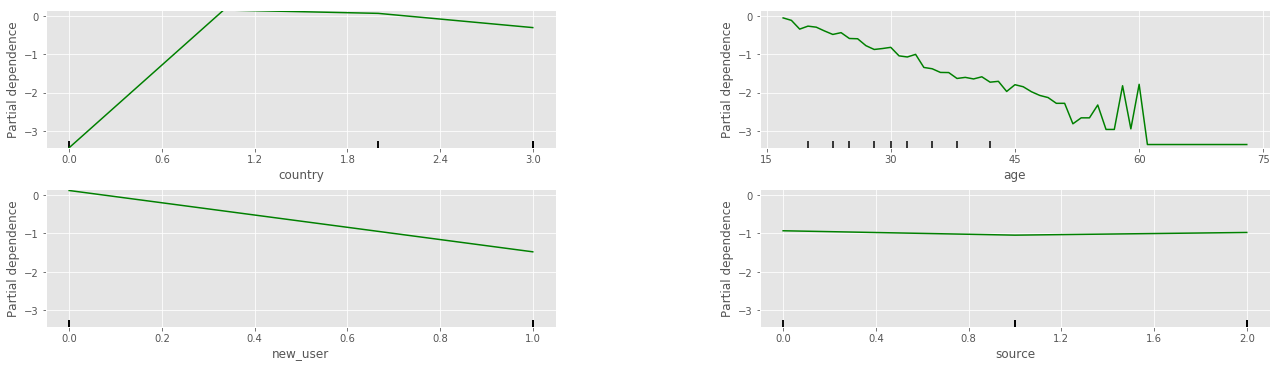

In [57]:
fig, axs = plot_partial_dependence(est, X_new_train, features=X_new_train.columns.values, feature_names=X_new.columns.values, 
                                   n_cols=2,figsize=(20,8) )

### Conclusions

1.The site is working very well for young users. Definitely let’s tell marketing to advertise and use
marketing channel which are more likely to reach young people


2.The site is working very well for Germany in terms of conversion. Again,
marketing should get more Germans. Big opportunity.


3.Users with old accounts do much better. Targeted emails with offers to bring them back to the site
could be a good idea to try


4.Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the
local culture, some payment issue or maybe it is just in English! Given how many users are based in
China, fixing this should be a top priority. Huge opportunity.


5.Maybe go through the UI and figure out why older users perform so poorly? From 30 y/o conversion
clearly starts dropping


6.If I know someone has visited many pages, but hasn’t converted, she almost surely has high
purchase intent. I could email her targeted offers or sending her reminders. Overall, these are
probably the easiest users to make convert